# Introduction to Argoverse-depth map

This is a simple tutorial that will show you how to interact with the Argoverse-tracking dataset and **create depth maps for monocular depth estimation** using our python package. See [github page](https://github.com/argoai/argoverse-api) for instructions on how to install the package.

Argoverse dataset can be download at [https://www.argoverse.org](https://www.argoverse.org) This tutorial assumes that you already download and extract all necessary data into a specific folder 

In [9]:
import os
import fnmatch
import glob

import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt

import argoverse
from argoverse.data_loading.argoverse_tracking_loader import ArgoverseTrackingLoader

In [11]:
class Lidar2Depth:
    """
       Convert 360 degree lidar point cloud to depth map corresponding to each ring camera
       for monocular depth estimation.
       
       Parameters
       ----------
       input_log_dir : path to individual log dir (e.g. path/to/3d20ae25-5b29-320d-8bae-f03e9dc177b9/)
       output_save_path : path to output dir (e.g. path/to/depth_dataset/)
    """

    def __init__(self, input_log_dir, output_save_path):
        self.input_log_dir = input_log_dir
        self.output_save_path = output_save_path
        self.log_id = os.path.basename(input_log_dir)
        print("Log ID ", self.log_id)

        # Load Argo data
        dataset = os.path.dirname(self.input_log_dir)
        self.argoverse_loader = ArgoverseTrackingLoader(dataset)
        self.argoverse_data = self.argoverse_loader.get(self.log_id)

        # 0-1 are ring cameras, 7 and 8 are stereo left and right
        # we are processing just the ring cameras
        self.ring_camera_list = self.argoverse_loader.CAMERA_LIST[0:6]

        # Count the number of lidar ply files in the log dir
        self.pylCounter = len(
            glob.glob1(os.path.join(self.input_log_dir, "lidar"), "*.ply")
        )

        # Setup depth dataset dir
        self.depth_data_dir_setup()

        # Extract depth data and ring camera frames
        self.depth_extraction()

    def depth_data_dir_setup(self):
        """
            Depth dataset structure
            +-- train/val
            |   +-- depth
            |   |   +-- 00c561b9-2057-358d-82c6-5b06d76cebcf
            |   |   |   +-- ring_front_center
            |   |   |   |   +-- 1.png
            |   |   |   |   +-- 2.png
            |   |   |   |   +--   .
            |   |   |   |   +--   .
            |   |   |   |   +-- n.png
            |   |   |   +-- ring_front_left
            |   |   |   +--        .
            |   |   |   +--        .
            |   |   |   +-- ring_side_right
            |   |   +-- 0ef28d5c-ae34-370b-99e7-6709e1c4b929
            |   |   |   +-- ring_front_center
            |   |   |   +--        .
            |   |   |   +--        .
            |   |   |   +-- ring_side_right
            |   |   +--            .
            |   |   +--            .
            |   +-- rgb
            |   |   +-- 00c561b9-2057-358d-82c6-5b06d76cebcf
            |   |   |   +-- ring_front_center
            |   |   |   |   +-- 1.png
            |   |   |   |   +--   .
            |   |   |   |   +-- n.png
            |   |   |   +-- ring_front_left
            |   |   |   +--        .
            |   |   |   +-- ring_side_right
            |   |   +-- 0ef28d5c-ae34-370b-99e7-6709e1c4b929
            |   |   |   +-- ring_front_center
            |   |   |   +-- ring_front_left
            |   |   |   +--        .
            |   |   |   +-- ring_side_right      
            |   |   +--            .
            |   |   +--            .            
        """
        type_train = "train"
        type_val = "val"
        if fnmatch.fnmatchcase(self.input_log_dir, "*" + type_train + "*"):
            self.save_name = os.path.join(self.output_save_path, "train")
        elif fnmatch.fnmatchcase(self.input_log_dir, "*" + type_val + "*"):
            self.save_name = os.path.join(self.output_save_path, "val")

        for camera_name in self.ring_camera_list:
            paths = [
                os.path.join(self.save_name, "depth", self.log_id, camera_name),
                os.path.join(self.save_name, "rgb", self.log_id, camera_name),
            ]
            for sub_path in paths:
                if not os.path.exists(sub_path):
                    os.makedirs(sub_path)

    def extract_lidar_image_pair(self):
        """
            For the provided cameraID and lidar ply file, 
            extract rgb image and corresponding lidar points in the fov.
        """

        self.img = self.argoverse_data.get_image_sync(
            self.lidaridx, camera=self.cameraID
        )

        objects = self.argoverse_data.get_label_object(self.lidaridx)
        calib = self.argoverse_data.get_calibration(self.cameraID)

        pc = self.argoverse_data.get_lidar(self.lidaridx)
        uv = calib.project_ego_to_image(pc).T
        lidaridx_ = np.where(
            np.logical_and.reduce(
                (
                    uv[0, :] >= 0.0,
                    uv[0, :] < np.shape(self.img)[1] - 1.0,
                    uv[1, :] >= 0.0,
                    uv[1, :] < np.shape(self.img)[0] - 1.0,
                    uv[2, :] > 0,
                )
            )
        )
        idx_ = lidaridx_[0]
        self.lidar_image_projection_points = uv[:, lidaridx_]

        if self.lidar_image_projection_points is None:
            print("No point image projection")
            return
        else:
            return self.lidar_image_projection_points

    def save_images(self):
        """
            Save the depth images and camera frame to the created dataset dir.
        """
        x_values = np.round(self.lidar_image_projection_points[0], 0).astype(int)
        y_values = np.round(self.lidar_image_projection_points[1], 0).astype(int)
        lidar_depth_val = self.lidar_image_projection_points[2]

        # Create a blank image to place lidar points as pixels with depth information
        blank_img = np.zeros([self.img.shape[0], self.img.shape[1]], dtype=np.uint16)
        blank_img[y_values, x_values] = lidar_depth_val

        # Multiple to maintain precision, while model training, remember to divide by 256
        # NOTE: 0 denotes a null value, rather than actually zero depth in the saved depth map
        pred_depth_scaled = blank_img * 256.0
        pred_depth_scaled = pred_depth_scaled.astype(np.uint32)
        pred_depth_scaled = Image.fromarray(pred_depth_scaled)
        raw_depth_path = os.path.join(
            self.save_name,
            "depth",
            self.log_id,
            str(self.cameraID),
            str(self.lidaridx) + ".png",
        )
        pred_depth_scaled.save(raw_depth_path) # Save Depth image

        img_rgb = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        raw_img_path = os.path.join(
            self.save_name,
            "rgb",
            self.log_id,
            str(self.cameraID),
            str(self.lidaridx) + ".png",
        )
        cv2.imwrite(raw_img_path, img_rgb, [cv2.IMWRITE_PNG_COMPRESSION, 0]) # Save RGB image

    def depth_extraction(self):
        """
            For every lidar file, extract ring camera frames and store it in the save dir
            along with depth map
        """
        for lidaridx in tqdm(range(self.pylCounter)):
            for cameraID in self.ring_camera_list:
                self.cameraID = cameraID
                self.lidaridx = lidaridx
                # Extract camera frames and associated lidar points
                self.extract_lidar_image_pair()
                # Save the above extracted images
                self.save_images()

## On sample data

**Argoverse 3D Tracking v1.1** comes in 4 training parts and 1 validation. After downloading from [Argoverse](https://www.argoverse.org/data.html), extract and edit `folders` with absolute or relative paths. `output_save_path` is where depth dataset will be created, modify it to your need. 

In [12]:
# Modify folders and output_save_path to your need.
folders = [
    "./Argoverse/full_data/extracted/argoverse-tracking/train1/",
    "./Argoverse/full_data/extracted/argoverse-tracking/train2/",
    "./Argoverse/full_data/extracted/argoverse-tracking/train3/",
    "./Argoverse/full_data/extracted/argoverse-tracking/train4/",
    "./Argoverse/full_data/extracted/argoverse-tracking/val/",
]
output_save_path = "./depth_dataset/"

for folder in folders:
    subfolders = [f.path for f in os.scandir(folder) if f.is_dir()]
    for input_log_dir in subfolders:
        Lidar2Depth(input_log_dir, output_save_path)
        break  # Remove break to run on all the logids
    break  # Remove break to run on all the logids

Log ID  230970eb-dc2e-3133-b252-ff3c6f5d4284


100%|██████████| 157/157 [07:21<00:00,  2.81s/it]


## Visualize

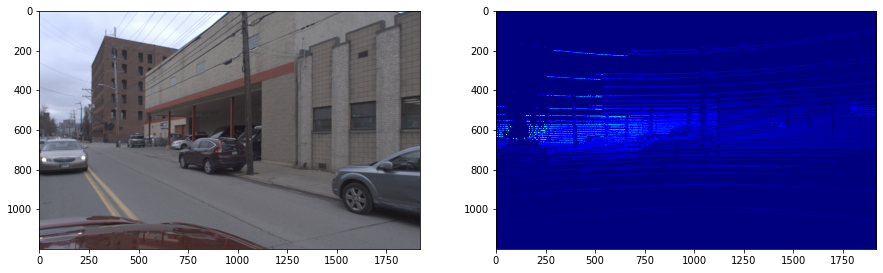

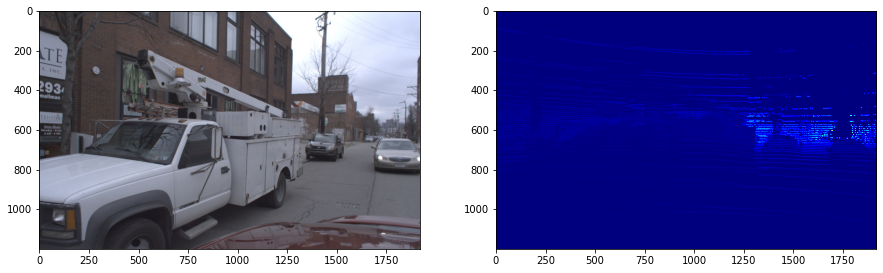

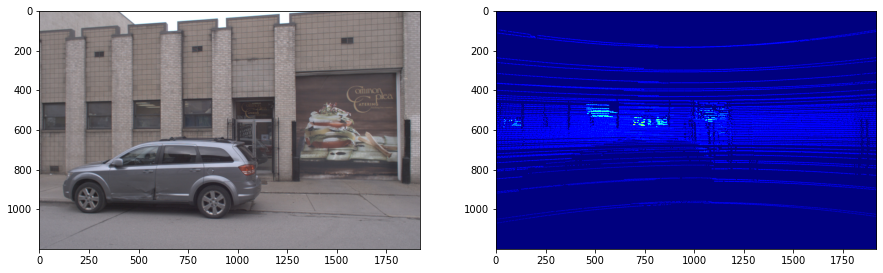

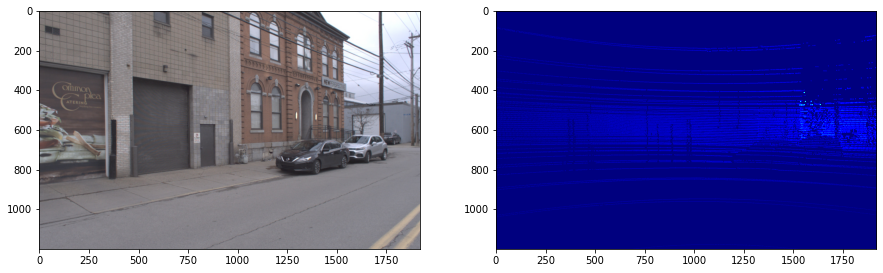

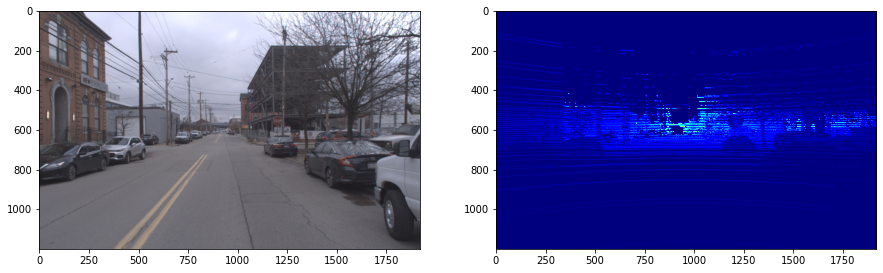

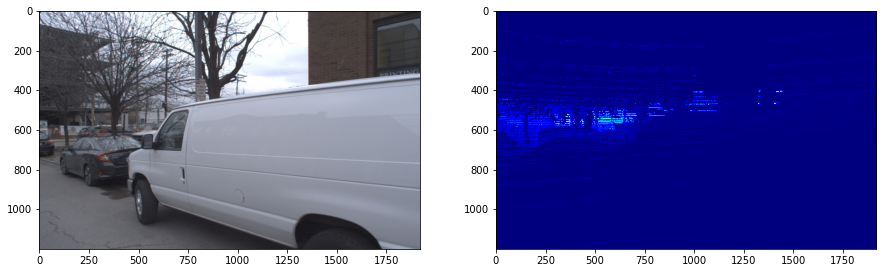

In [13]:
# Modify train_path, img_name and corresponding log_id to visualize generated depth maps from all the ring cameras.
img_name = "110.png"
log_id = "230970eb-dc2e-3133-b252-ff3c6f5d4284"
train_path = "./depth_dataset/train/"

rgb_path = os.path.join(train_path, "rgb", log_id)
subfolders = [f.path for f in os.scandir(rgb_path) if f.is_dir()]
for camera_id in subfolders:
    camera_id = os.path.basename(camera_id)
    rgb_image_path = os.path.join(train_path, "rgb", log_id, camera_id, img_name)
    depth_image_path = os.path.join(train_path, "depth", log_id, camera_id, img_name)
    rgb_image = cv2.cvtColor(cv2.imread(rgb_image_path, -1), cv2.COLOR_BGR2RGB)
    depth_image = cv2.imread(depth_image_path, -1) / 256
    
    # Dilate for better visualization
    dilated_depth_image = cv2.dilate(
        depth_image, kernel=np.ones((2, 2), np.uint8), iterations=3
    )
    plt.figure(figsize=(15, 7))
    plt.subplot(121)
    plt.imshow(rgb_image)
    plt.subplot(122)
    plt.imshow(dilated_depth_image, cmap="jet")
    plt.show()

## Genererate rgb to depth mapping for model training

Mapping of RGB image to Depth image is generated and saved in a text file, which will be used for model training. Below code snippet is for train, repeat for validation set by changing the paths.

In [14]:
rgb_path = "./depth_dataset/train/rgb/"
depth_path = "./depth_dataset/train/depth/"
myfile = open(
    "./depth_dataset/train/argo_train_files_with_gt.txt",
    "w",
)

for f in os.scandir(rgb_path):
    if f.is_dir():
        log_id = os.path.basename(f.path)
        find_path = os.path.join(f.path, "**/*.png")
        for file_name in glob.glob(find_path, recursive=True):
            path_log_cam, img_name = os.path.split(file_name)
            to_be_added_path = os.path.join(os.path.basename(path_log_cam), img_name)
            rgb_file_path = os.path.join(log_id, to_be_added_path)
            depth_file_path = os.path.join(depth_path, rgb_file_path)
            if os.path.isfile(depth_file_path) and os.access(depth_file_path, os.R_OK):
                gt_string = rgb_file_path + " " + rgb_file_path + " 1396.478"  # Focal
                print(gt_string)
                myfile.write(gt_string + "\n")
            else:
                print("Either the file is missing or not readable")
            break  # Remove break to run on all the images
    break  # Remove break to run on all the logids

230970eb-dc2e-3133-b252-ff3c6f5d4284/ring_rear_left/27.png 230970eb-dc2e-3133-b252-ff3c6f5d4284/ring_rear_left/27.png 1396.478


<div align="center">
<b> Now use the above data to train your monocular depth estimation model and show us what you can build using our data </b>
</div>